In [1]:
using Random
Random.seed!(4649373)

using Distributions
using QuadGK
using Roots
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(400, 250))

In [2]:
function winningrate(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution
    )
    quadgk(y -> cdf(distx, y)*pdf(disty, y), extrema(disty)...)[1]
end

function tieshift(
        distx::ContinuousUnivariateDistribution,
        disty::ContinuousUnivariateDistribution;
        p = 1/2
    )
    find_zero(0.0) do a
        winningrate(distx + a, disty) - p
    end
end

@show distx = Exponential(1)
@show disty = Exponential(1.5)
@show winningrate(distx, disty)
println()
@show tiesh = tieshift(distx, disty)
@show mediansh = median(disty) - median(distx)
@show meansh = mean(disty) - mean(distx)
println()
@show winningrate(distx + tiesh, disty)
@show winningrate(distx + mediansh, disty)
@show winningrate(distx + meansh, disty)
println()
@show median(distx + tiesh)
@show median(distx + mediansh)
@show median(distx + meansh)
@show median(disty)
println()
@show mean(distx + tiesh)
@show mean(distx + mediansh)
@show mean(distx + meansh)
@show mean(disty)
;

distx = Exponential(1) = Exponential{Float64}(θ=1.0)
disty = Exponential(1.5) = Exponential{Float64}(θ=1.5)
winningrate(distx, disty) = 0.6000000000000003

tiesh = tieshift(distx, disty) = 0.27348233139104033
mediansh = median(disty) - median(distx) = 0.3465735902799726
meansh = mean(disty) - mean(distx) = 0.5

winningrate(distx + tiesh, disty) = 0.5
winningrate(distx + mediansh, disty) = 0.47622031634305906
winningrate(distx + meansh, disty) = 0.4299187894696709

median(distx + tiesh) = 0.9666295119509856
median(distx + mediansh) = 1.0397207708399179
median(distx + meansh) = 1.1931471805599454
median(disty) = 1.0397207708399179

mean(distx + tiesh) = 1.2734823313910404
mean(distx + mediansh) = 1.3465735902799727
mean(distx + meansh) = 1.5
mean(disty) = 1.5


In [3]:
using Distributions

@doc raw"""
    brunner_munzel_test(X, Y; p = 1/2)

この函数は数値のベクトルのデータ `X`, `Y` について, 
Brunner-Munzel検定関係の統計量達を計算する. 詳細は以下の通り.

函数 $H(x, y)$ と $\hat{p}$, $H^x_i$, $H^y_j$, $\bar{H}^x$, $\bar{H}^y$ を次のように定める:

```math
\begin{aligned}
&
m = \mathrm{length}(X), \quad
n = \mathrm{length}(Y), \quad
x_i = X[i], \quad
y_j = Y[j],
\\ &
\hat{p} = \frac{1}{mn}\sum_{i=1}^m \sum_{j=1}^n H(x_i, y_j),
\\ &
H(x, y) = \begin{cases} 1 & (x < y) \\ 1/2 & (x = y) \\ 0 & (x > y), \end{cases}
\\ &
H^x_i = \sum_{j=1}^n H(y_j, x_i), \quad
H^y_j = \sum_{i=1}^m H(x_i, y_j),
\\ &
\bar{H}^x = \frac{1}{m} \sum_{i=1}^m H^x_i = n - n\hat{p}, \quad
\bar{H}^y = \frac{1}{n} \sum_{j=1}^n H^y_j = m\hat{p}.
\end{aligned}
```

この函数は以下達の named tuple で返す:

```math
\begin{aligned}
&
\mathrm{phat} = 
\hat{p} = \frac{\bar{H}^y - \bar{H}^x + n}{m + n},
\\ &
\mathrm{sx2} =
\hat{\sigma}_x^2 = \frac{1}{n^2}\frac{1}{m-1}\sum_{i=1}^m (H^x_i - \bar{H}^x)^2,
\\ &
\mathrm{sy2} =
\hat{\sigma}_y^2 = \frac{1}{m^2}\frac{1}{n-1}\sum_{j=1}^n (H^y_j - \bar{H}^y)^2,
\\ &
\mathrm{sehat} = 
\widehat{\mathrm{se}} = \sqrt{\frac{\hat{\sigma}_x^2}{m} + \frac{\hat{\sigma}_y^2}{n}}, 
\\ &
\mathrm{tvalue} = t = \frac{\hat{p} - p}{\widehat{\mathrm{se}}},
\\ &
\mathrm{df} =
\nu = 
\frac
{\left(\hat{\sigma}_x^2/m + \hat{\sigma}_y^2/n\right)^2}
{
\dfrac{\left(\hat{\sigma}_x^2/m\right)^2}{m-1} +
\dfrac{\left(\hat{\sigma}_y^2/n\right)^2}{n-1}
},
\\ &
\mathrm{pvalue} =
2\mathrm{ccdf}(\mathrm{TDist}(\nu), |t|),
\\ &
\mathrm{p} = p.
\end{aligned}
```
"""
function brunner_munzel_test(X, Y; p=1/2)
    m, n = length(X), length(Y)
    phat = mean((x < y) + (x == y)/2 for x in X, y in Y)
    Hbarx = n*(1 - phat)
    Hbary = m*phat
    sx2 = 1/n^2 * 1/(m-1) * sum(x -> (sum((y < x) + (y == x)/2 for y in Y) - Hbarx)^2, X)
    sy2 = 1/m^2 * 1/(n-1) * sum(y -> (sum((x < y) + (x == y)/2 for x in X) - Hbary)^2, Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
    (; phat, sehat, tvalue, df, pvalue, p)
end

@doc raw"""
    pvalue_brunner_munzel_test(X, Y; p = 1/2)

この函数はBrunner-Munzel検定のP値 `pvalue` を返す.
"""
pvalue_brunner_munzel_test(X, Y; p=1/2) = brunner_munzel_test(X, Y; p).pvalue

using RCall
@rimport lawstat
X = rand(100)
Y = rand(100)
pvalue_brunner_munzel_test(X, Y), rcopy(lawstat.brunner_munzel_test(X, Y))[:p_value]

(0.10237071161776065, 0.10237071161776079)

In [4]:
function mann_whitney_u_test(X, Y; correct=true)
    m, n = length(X), length(Y)
    phat = mean((x < y) + (x == y)/2 for x in X, y in Y)
    sehat = √((m+n+1)/(12m*n))
    zvalue = (phat - 1/2)/sehat
    correction = correct/(2m*n*sehat)
    pvalue = 2ccdf(Normal(), max(0, abs(zvalue) - correction))
    (; phat, sehat, zvalue, pvalue)
end

pvalue_mann_whitney_u_test(X, Y; correct=true) = mann_whitney_u_test(X, Y; correct).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_mann_whitney_u_test(X, Y), pvalue(ApproximateMannWhitneyUTest(X, Y))

(0.04990007292443201, 0.04990007292443193)

In [5]:
X = randn(10)
Y = randn(10)
pvalue_mann_whitney_u_test(X, Y), pvalue(ApproximateMannWhitneyUTest(X, Y))

(0.6231762238821172, 0.6231762238821172)

In [6]:
function student_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    S2 = ((m-1)*SX2 + (n-1)*SY2) / (m+n-2)
    sehat2 = S2 * (1/m + 1/n)
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = m + n - 2
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_student_t_test(X, Y; μ = 0.0) = student_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_student_t_test(X, Y), pvalue(EqualVarianceTTest(X, Y))

(0.901590659374404, 0.901590659374404)

In [7]:
function welch_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    sehat2 = SX2/m + SY2/n
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = sehat2^2 / ((SX2/m)^2/(m-1) + (SY2/n)^2/(n-1))
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_welch_t_test(X, Y; μ = 0.0) =welch_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_welch_t_test(X, Y), pvalue(UnequalVarianceTTest(X, Y))

(0.38055645109442215, 0.38055645109442215)

In [8]:
undefarray(T::Type, n...) = Array{T}(undef, n...)
undefarray(n...) = undefarray(Float64, n...)
ECDF(A, x) = count(≤(x), A) / length(A)

list_skewness = Tuple((β, β) for β in 0:0.5:3)
list_skewness2 = Tuple((β, β-0.5) for β in 1:0.5:3)
list_stdratio = reverse((1.0, 1.1, 1.25, 1.5, 2.0))

rd(x) = round(100x; digits=1)

function print_sim(;
        list_skewness=list_skewness,
        list_stdratio = list_stdratio,
        distfunc = gammadist,
        distfuncx = distfunc,
        distfuncy = distfunc,
        α = 0.05,
        L = 10^5,
        m = 25,
        n = 25,
        shifttype = :auto,
        correct = true,
    )
    
    nx = length(list_skewness)
    ny = length(list_stdratio)
    # `er` stands for "true alpha Error Rate".
    er_wmw = undefarray(nx, ny)
    er_bm = undefarray(nx, ny)
    er_st = undefarray(nx, ny)
    er_we = undefarray(nx, ny)
    
    for (i, (β1, β2)) in enumerate(list_skewness), (j, σ) in enumerate(list_stdratio)
        distx = distfuncx(σ, β1)
        disty = distfuncy(1, β2)
        (; pval_wmw, pval_bm, pval_st, pval_we) = sim(distx, disty, m, n; shifttype, correct, L)
        er_wmw[i, j] = ECDF(pval_wmw, α)
        er_bm[i, j] = ECDF(pval_bm, α)
        er_st[i, j] = ECDF(pval_st, α)
        er_we[i, j] = ECDF(pval_we, α)
    end
    
    println("skewness = ", list_skewness)
    println("stdratio = ", list_stdratio)
    println("distx = $distfuncx,  disty = $distfuncy, m = $m,  n = $n,  shifttype = $shifttype")
    println()
    println("Wilcoxon-Mann-Whitney:"); Base.print_matrix(stdout, rd.(er_wmw'))
    println("\n\nBrunner-Munzel:"); Base.print_matrix(stdout, rd.(er_bm'))
    println("\n\nStudent t:"); Base.print_matrix(stdout, rd.(er_st'))
    println("\n\nWelch t:"); Base.print_matrix(stdout, rd.(er_we'))
    println("\n")
end

function sim(distx, disty, m, n; shifttype=:mean, correct=true, L=10^5)
    if shifttype != :none
        meansh = mean(disty) - mean(distx)
        mediansh = median(disty) - median(distx)
        tiesh = tieshift(distx, disty)
    end
    if shifttype == :mean
        distx_sh = distx + meansh
    elseif shifttype == :median
        distx_sh = distx + mediansh
    elseif shifttype == :tie || shifttype == :auto
        distx_sh = distx + tiesh
    else
        distx_sh = distx
    end
    
    pval_wmw = undefarray(L)
    pval_bm = undefarray(L)
    pval_st = undefarray(L)
    pval_we = undefarray(L)
    nth = Threads.nthreads()
    Xtmp = [undefarray(m) for _ in 1:nth]
    Ytmp = [undefarray(n) for _ in 1:nth]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx_sh, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
        pval_wmw[i] = pvalue_mann_whitney_u_test(X, Y; correct)
        pval_bm[i] = pvalue_brunner_munzel_test(X, Y)
        if shifttype == :auto
            @. X = X - tiesh + meansh
        end
        pval_st[i] = pvalue_student_t_test(X, Y)
        pval_we[i] = pvalue_welch_t_test(X, Y)
    end
    
    (; pval_wmw, pval_bm, pval_st, pval_we)
end

function print_sim(distx, disty, m, n; shifttype=:mean, L=10^5, α=0.05)
    (; pval_wmw, pval_bm, pval_st, pval_we) = sim(distx, disty, m, n; shifttype, L)
    er_wmw = ECDF(pval_wmw, α)
    er_bm = ECDF(pval_bm, α)
    er_st = ECDF(pval_st, α)
    er_we = ECDF(pval_we, α)
    println("distx = $distx")
    println("disty = $disty")
    println("m = $m,  n = $n,  shifttype = $shifttype")
    println()
    println("Wilcoxon-Mann-Whitney: ", rd(er_wmw), "%")
    println("Brunner-Munzel:        ", rd(er_bm), "%")
    println("Student t:             ", rd(er_st), "%")
    println("Welch t:               ", rd(er_we), "%")
    println()
end

print_sim (generic function with 2 methods)

In [9]:
function plot_power(;
        shifttype = :none,
        distxfunc = μ -> Normal(μ, 1),
        distyfunc = μ -> MixtureModel([Normal(0, 1), Normal(20, 1)], [0.95, 0.05]),
        M = 101,
        μ = range(-2, 8, M),
        m = fill(20, M),
        n = fill(20, M),
        α = 0.05,
        L = 10^4,
        output = Bool[1, 1, 1, 1],
        xtick = -10:10,
        ytick = 0:0.1:1,
    )
    power_wmw = undefarray(M)
    power_bm = undefarray(M)
    power_st = undefarray(M)
    power_we = undefarray(M)

    @time Threads.@threads for i in 1:M
        pval_wmw, pval_bm, pval_st, pval_we =
            sim(distxfunc(μ[i]), distyfunc(μ[i]), m[i], n[i]; shifttype, L)
        power_wmw[i] = ECDF(pval_wmw, α)
        power_bm[i] = ECDF(pval_bm, α)
        power_st[i] = ECDF(pval_st, α)
        power_we[i] = ECDF(pval_we, α)
    end

    plot()
    output[1] && plot!(μ, power_wmw; label="WMW", c=1)
    output[2] && plot!(μ, power_bm; label="BM", ls=:dash, c=2)
    output[3] && plot!(μ, power_st; label="Student", ls=:dashdot, c=3)
    output[4] && plot!(μ, power_we; label="Welch", ls=:dashdotdot, c=4)
    plot!(; xtick, ytick)
    plot!(size=(500, 300))
end

plot_power (generic function with 1 method)

mean(disty) = 1.0
std(disty) = 4.47213595499958
var(disty) = 20.0


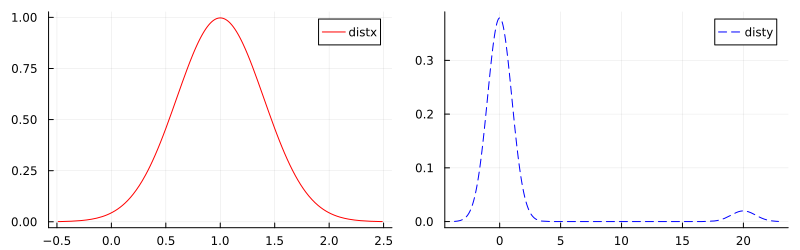

In [10]:
distx = Normal(1, 0.4)
disty = MixtureModel([Normal(0, 1), Normal(20, 1)], [0.95, 0.05])
@show mean(disty) std(disty) var(disty)
P = plot(distx; label="distx", c=:red)
Q = plot(1disty; label="disty", c=:blue, ls=:dash)
plot(P, Q; size=(800, 250))

  7.363698 seconds (21.24 M allocations: 1.075 GiB, 7.45% gc time, 742.43% compilation time)


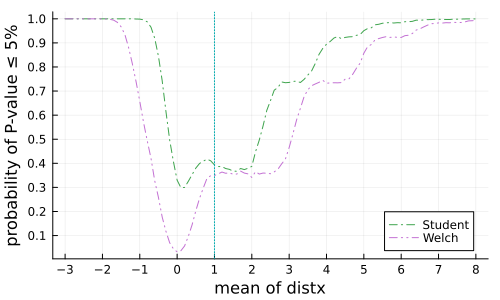

In [11]:
disty = MixtureModel([Normal(0, 1), Normal(20, 1)], [0.95, 0.05])
M = 111
plot_power(;
    distxfunc = μ -> Normal(μ, 0.4),
    distyfunc = μ -> disty,
    M,
    μ = range(-3, 8, M), 
    m = fill(50, M),
    n = fill(20, M),
    α = 0.05,
    L = 10^4,
    output = Bool[0, 0, 1, 1],
    xtick = -10:10,
    ytick = 0:0.1:1,
)
#vline!([tieshift(Normal(0, 0.5), disty)]; label="", ls=:dot, c=5)
vline!([mean(disty)]; label="", ls=:dot, c=6)
plot!(xguide="mean of distx", yguide="probability of P-value ≤ 5%")

  1.904970 seconds (16.72 M allocations: 874.031 MiB, 11.12% gc time, 99.81% compilation time)


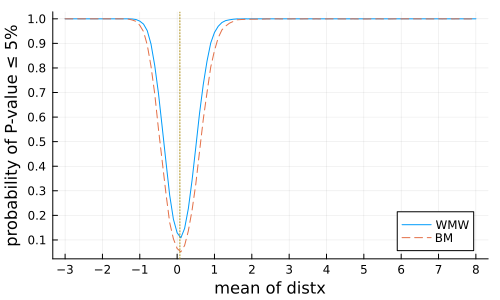

In [12]:
disty = MixtureModel([Normal(0, 1), Normal(20, 1)], [0.95, 0.05])
M = 111
plot_power(;
    distxfunc = μ -> Normal(μ, 0.4),
    distyfunc = μ -> disty,
    M,
    μ = range(-3, 8, M), 
    m = fill(50, M),
    n = fill(20, M),
    α = 0.05,
    L = 10^4,
    output = Bool[1, 1, 0, 0],
    xtick = -10:10,
    ytick = 0:0.1:1,
)
vline!([tieshift(Normal(0, 0.5), disty)]; label="", ls=:dot, c=5)
#vline!([mean(disty)]; label="", ls=:dot, c=6)
plot!(xguide="mean of distx", yguide="probability of P-value ≤ 5%")

  4.067999 seconds (9.67 M allocations: 519.216 MiB, 7.96% gc time, 100.22% compilation time)


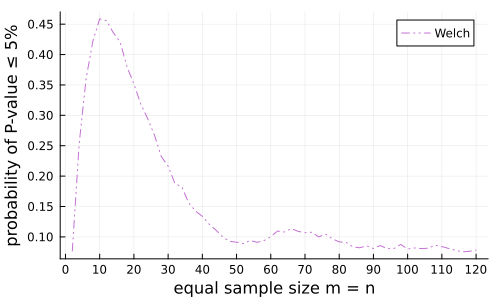

In [13]:
disty = MixtureModel([Normal(0, 1), Normal(20, 1)], [0.95, 0.05])
μ = 2:2:120
M = length(μ)
plot_power(;
    distxfunc = μ -> Normal(mean(disty), 0.4),
    distyfunc = μ -> disty,
    M,
    μ,
    m = μ,
    n = μ,
    α = 0.05,
    L = 10^4,
    output = Bool[0, 0, 0, 1],
    xtick = 0:10:200,
    ytick = 0:0.05:1
)
plot!(xguide="equal sample size m = n", yguide="probability of P-value ≤ 5%")

  3.663114 seconds (11.46 M allocations: 821.766 MiB, 5.09% gc time, 58.11% compilation time)


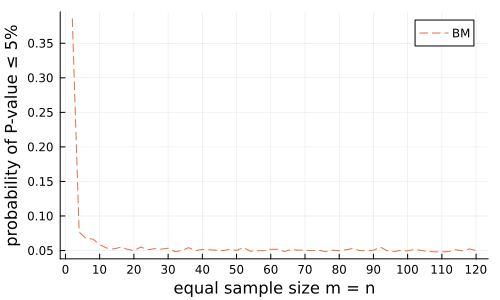

In [14]:
disty = MixtureModel([Normal(0, 1), Normal(20, 1)], [0.95, 0.05])
μ = 2:2:120
M = length(μ)
plot_power(;
    shifttype = :tie,
    distxfunc = μ -> Normal(mean(disty), 0.4),
    distyfunc = μ -> disty,
    M,
    μ,
    m = μ,
    n = μ,
    α = 0.05,
    L = 10^4,
    output = Bool[0, 1, 0, 0],
    xtick = 0:10:200,
    ytick = 0:0.05:1
)
plot!(xguide="equal sample size m = n", yguide="probability of P-value ≤ 5%")

 14.902283 seconds (19.03 M allocations: 1.358 GiB, 3.06% gc time, 5.67% compilation time)


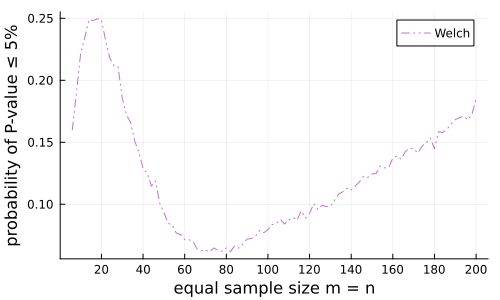

In [15]:
disty = MixtureModel([Normal(0, 1), Normal(20, 1)], [0.95, 0.05])
μ = 6:2:200
M = length(μ)
plot_power(;
    distxfunc = μ -> Normal(mean(disty)-0.4, 0.4),
    distyfunc = μ -> disty,
    M,
    μ,
    m = μ,
    n = μ,
    α = 0.05,
    L = 10^4,
    output = Bool[0, 0, 0, 1],
    xtick = 0:20:200,
    ytick = 0:0.05:1
)
plot!(xguide="equal sample size m = n", yguide="probability of P-value ≤ 5%")

 15.855463 seconds (20.11 M allocations: 1.487 GiB, 3.18% gc time, 10.53% compilation time)


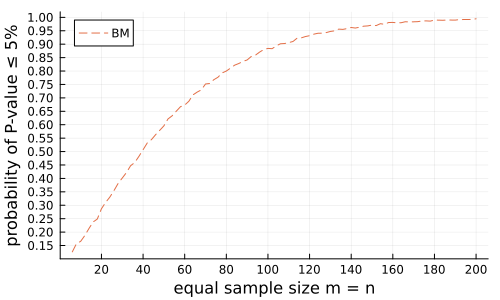

In [16]:
disty = MixtureModel([Normal(0, 1), Normal(20, 1)], [0.95, 0.05])
distx = Normal(tieshift(Normal(0, 0.4)-0.4, disty), 0.4)
μ = 6:2:200
M = length(μ)
plot_power(;
    distxfunc = μ -> distx,
    distyfunc = μ -> disty,
    M,
    μ,
    m = μ,
    n = μ,
    α = 0.05,
    L = 10^4,
    output = Bool[0, 1, 0, 0],
    xtick = 0:20:200,
    ytick = 0:0.05:1
)
plot!(xguide="equal sample size m = n", yguide="probability of P-value ≤ 5%")